# Location Embeddings

## Imports

In [1]:
import sys
sys.path.append("../")

In [2]:
import warnings
import einops
import random
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import torch
import lightning as L
import pandas as pd
from einops import rearrange, reduce
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader

from src.model_clay import CLAYModule
from src.datamodule import ClayDataset, ClayDataModule

warnings.filterwarnings("ignore")

/home/mjonir/mambaforge/envs/claymodel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
L.seed_everything(42)

Seed set to 42


42

In [4]:
DATA_DIR = "../data/02" # data directory for all chips
CKPT_PATH = "../checkpoints/v0/mae_epoch-24_val-loss-0.46.ckpt" # path of best model checkpoint for Clay v0

## Load Model & DataModule

In [5]:
# Load the model & set in eval mode
model = CLAYModule.load_from_checkpoint(CKPT_PATH, mask_ratio=0.7)
model.eval();

In [6]:
data_dir = Path(DATA_DIR)

# Load the Clay DataModule
ds = ClayDataset(chips_path=list(data_dir.glob("**/*.tif")))
dm = ClayDataModule(data_dir=str(data_dir), batch_size=100)
dm.setup(stage="fit")

# Load the train DataLoader
trn_dl = iter(dm.train_dataloader())

Total number of chips: 414


In [7]:
# Load the first batch of chips
batch = next(trn_dl)
batch.keys()

dict_keys(['pixels', 'bbox', 'epsg', 'date', 'latlon', 'timestep', 'source_url'])

In [8]:
# Save a copy of batch to visualize later
_batch = batch["pixels"].detach().clone().cpu().numpy()

## Pass model through the CLAY model

In [9]:
# Pass the pixels through the encoder & decoder of CLAY
with torch.no_grad():
    # Move data from to the device of model
    batch["pixels"] = batch["pixels"].to(model.device)
    batch["timestep"] = batch["timestep"].to(model.device)
    batch["latlon"] = batch["latlon"].to(model.device)

    # Pass pixels, latlon, timestep through the encoder to create encoded patches
    unmasked_patches, unmasked_indices, masked_indices, masked_matrix = model.model.encoder(batch)

    # Pass the unmasked_patches through the decoder to reconstruct the pixel space
    pixels = model.model.decoder(unmasked_patches, unmasked_indices, masked_indices)

## Extract Location & Timestep Embeddings

In CLAY, the encoder receives unmasked patches, latitude-longitude data, and timestep information. Notably, the last 2 embeddings from the encoder specifically represent the latitude-longitude and timestep embeddings.

In [10]:
latlon_embeddings = unmasked_patches[:,-2,:].detach().cpu().numpy()
time_embeddings = unmasked_patches[:,-1,:].detach().cpu().numpy()

# Get normalized latlon that were input to the model
latlon = batch["latlon"].detach().cpu().numpy()

We will just focus on location embeddings in this notebook

In [11]:
latlon.shape, latlon_embeddings.shape

((100, 2), (100, 768))

> Latitude & Longitude map to 768 dimentional vector

## Preform PCA over the location embeddings to visualize them in 2 dimension

In [12]:
pca = PCA(n_components=2)
latlon_embeddings = pca.fit_transform(latlon_embeddings)
latlon_embeddings.shape

(100, 2)

## Create clusters of normalized latlon & latlon embeddings to check if there are any learned patterns in them after training

Latlon Cluster

In [13]:
kmeans = KMeans(n_clusters=5)
kmeans.fit_transform(latlon);
latlon = np.column_stack((latlon, kmeans.labels_))

Latlon Embeddings Cluster

In [14]:
kmeans = KMeans(n_clusters=5)
kmeans.fit_transform(latlon_embeddings)
latlon_embeddings = np.column_stack((latlon_embeddings, kmeans.labels_))

In [15]:
latlon.shape, latlon_embeddings.shape

((100, 3), (100, 3))

> We are a third dimension to latlon & latlon embeddings with cluster labels

## Plot latlon clusters

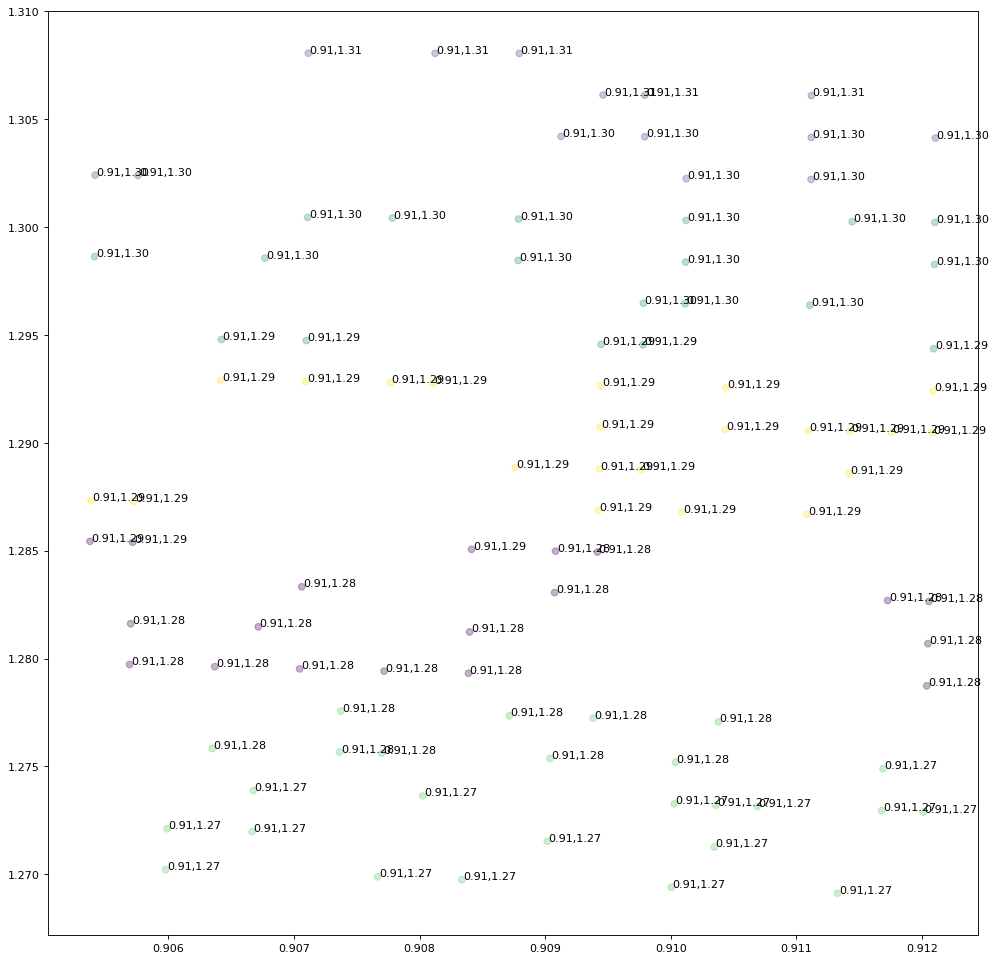

In [16]:
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(latlon[:,0], latlon[:,1], c=latlon[:,2], label='Actual', alpha=0.3)

for i in (range(100)):
    txt = f"{latlon[:,0][i]:.2f},{latlon[:, 1][i]:.2f}"
    plt.annotate(txt, (latlon[:, 0][i] + 1e-5, latlon[:, 1][i] + 1e-5))

> As we see in the scatter plot above, there is nothing unique about latlon that go into the model, they are cluster based on their change in longitude values above

## Plot latlon embeddings cluster

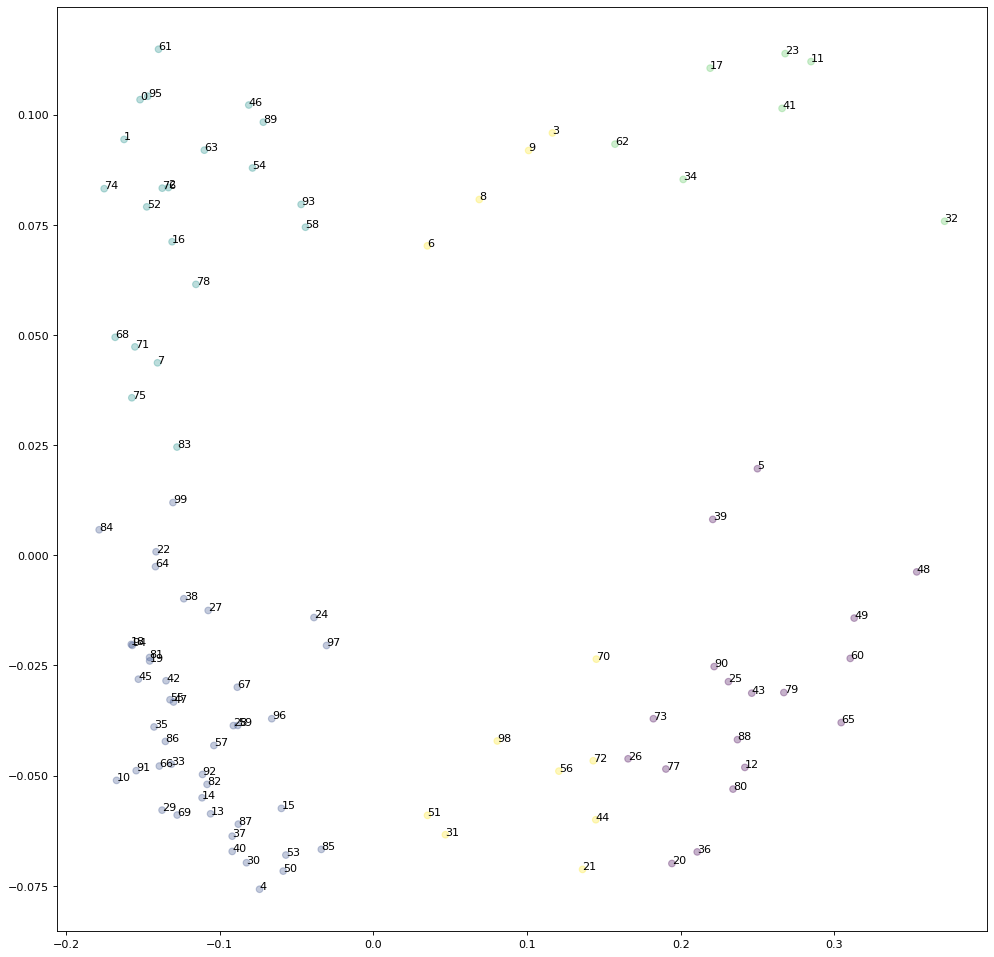

In [17]:
plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(latlon_embeddings[:,0], latlon_embeddings[:,1], c=latlon_embeddings[:,2], label='Predicted', alpha=0.3)
for i in (range(100)):
    txt = i
    plt.annotate(txt, (latlon_embeddings[:, 0][i], latlon_embeddings[:, 1][i]))

In [18]:
def show_cluster(ids):
    fig,axes = plt.subplots(1, len(ids), figsize=(10,5))
    for i,ax in zip(ids, axes.flatten()):
        img_path = batch["source_url"][i]
        img = rio.open(img_path).read([3,2,1]).transpose(1,2,0)
        img = (img - img.min())/(img.max() - img.min())
        ax.imshow(img)
        ax.set_axis_off()

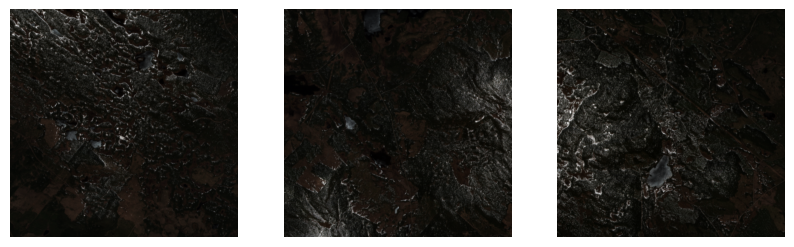

In [19]:
show_cluster((87, 37, 40))

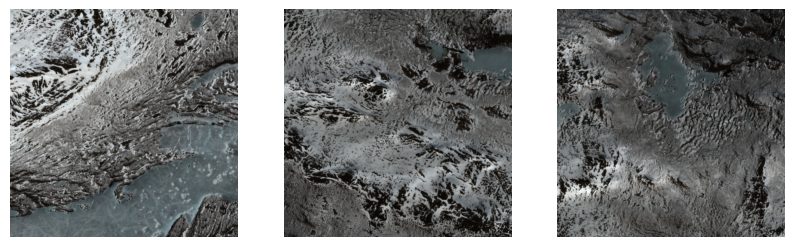

In [21]:
show_cluster((23, 11, 41))

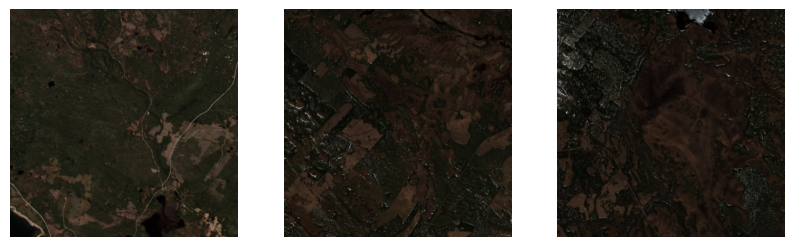

In [24]:
show_cluster((68, 71, 7))

> We can see location embedding capturing semantic information as well